In [ ]:
# connect to Google Drive 

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Import libraries

import pandas as pd
import numpy as np
import cv2
import random
import matplotlib.pyplot as plt
import plotly.express as px
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as T
import torchvision.transforms.functional as TF
import sys
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from PIL import Image
from pathlib import Path
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.io as pio

In [ ]:
# View data

df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/AML Assignment 02/train.csv')
print(df.shape)
df.head()

(28709, 2)


,emotion,pixels
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,231 212 156 164 174 138 161 173 182 200 106 38...
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...


In [ ]:
# Examine columns

for col in df.columns:
    print(col)

emotion
pixels


In [ ]:
# check how many 'emotion' types
df['emotion'].unique()

array([0, 2, 4, 6, 3, 5, 1])

In [ ]:
emotions = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

# Count the occurrences of each category
category_counts = df['emotion'].value_counts()

# # Convert the value counts to a DataFrame
category_counts_df = category_counts.reset_index()
category_counts_df.columns = ['Emotion', 'Frequency']

# # Create a bar plot using plotly
fig = px.bar(category_counts_df, x='Emotion', y='Frequency', text='Frequency')

# # Customize the plot
fig.update_traces(texttemplate='%{text:.2s}', textposition='outside')
fig.update_layout(title_text='Emotion Distribution: Angry: 0, Disgust: 1, Fear: 2, Happy: 3, Sad: 4, Surprise: 5, Neutral: 6', xaxis_title='Emotion', yaxis_title='Frequency')

# # Show the plot
fig.show()

In [ ]:
# custom dataset class
class FERDataset(Dataset):
    def __init__(self, data, transform=None):
      self.images = []
      self.labels = []
      self.transform = transform

      for idx in range(len(data.index)):
        image = np.array(eval("[" + data.iloc[idx].pixels.replace(" ", " ,") + "]")).reshape(48, 48, -1).astype(np.uint8)
        self.images.append(image)
        self.labels.append(data.iloc[idx, 0])

    def __len__(self):
      return len(self.labels)
    def add(self, image, label):
      self.images.append(image)
      self.labels.append(label)
    def delete(self, image, label):
      self.images.remove(image)
      self.labels.remove(label)
    def empty(self):
      self.images.clear
      self.labels.clear
      return self
    def __getitem__(self, idx):
      image = self.images[idx]
      label = self.labels[idx]
      
      if self.transform:
        image = self.transform(self.images[idx])
        return image, label

In [ ]:
# split data
def load_dataset(csv_file, transform, emotions_to_remove):
    data = pd.read_csv(csv_file)
    for e in emotions_to_remove:
      data = data[data['emotion'] != e]
    y = data.emotion
    train_data, test_data = train_test_split(data, test_size=0.2, random_state=42, stratify=y)
    train_dataset = FERDataset(train_data, transform=transform)
    test_dataset = FERDataset(test_data, transform=transform)
    
    return train_dataset, test_dataset

In [ ]:
# Define the transformations to be applied to your dataset
transform = T.Compose([  
    T.ToPILImage(),
    T.ToTensor(),
    T.Normalize(mean=[0.5], std=[0.5]),
    #T.Normalize((0.5), (0.5)),
    #T.Normalize(mean=[0.5], std=[0.5 * 2]),
    #T.Lambda(lambda x: torch.mul(x, 0.5) + 0.5),
    T.RandomHorizontalFlip(),
    #T.RandomVerticalFlip(p=1.0),
    #T.TenCrop(size = 48, vertical_flip = True),
    #T.RandomRotation(degrees=10),
    #T.RandomCrop(size=44, padding=4),
])

# Option to remove certain emotions for testing
# 0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral
emotions_to_remove = []
train_dataset, test_dataset = load_dataset('/content/drive/MyDrive/Colab Notebooks/AML Assignment 02/train.csv', transform, emotions_to_remove)
length = len(train_dataset)
print(f"Length of Datset is {length}")


Length of Datset is 22967


In [ ]:
# Augment the data further
emot = 1 # increase the number of 'disgust' emotions in the dataset

for i in range(length):
  if train_dataset[i][1] == emot:
    temp = TF.hflip(train_dataset[i][0])
    train_dataset.add(temp, train_dataset[i][1])
length = len(train_dataset)
print(f"Datset is {length} after horizontal flipping of {emotions[emot]}")

for j in range(length):
  if train_dataset[j][1] == emot:
    temp = TF.rotate(train_dataset[j][0], random.randint(-10, 10))
    train_dataset.add(temp, train_dataset[j][1])
length = len(train_dataset)
print(f"Datset is {length} after random rotation of {emotions[emot]}")



Datset is 23316 after horizontal flipping of Disgust
Datset is 24014 after random rotation of Disgust


In [ ]:
# view scaling
train_dataset[0][0]

tensor([[[ 0.6000,  0.5765,  0.6078,  ..., -0.8431, -0.6706, -0.6941],
         [ 0.5843,  0.5529,  0.5843,  ..., -0.8431, -0.7333, -0.7412],
         [ 0.5216,  0.5059,  0.5686,  ..., -0.8431, -0.8353, -0.7804],
         ...,
         [ 0.3569,  0.3098,  0.3255,  ...,  0.1608,  0.0902, -0.0431],
         [ 0.3490,  0.3490,  0.3412,  ...,  0.1451,  0.0667, -0.0980],
         [ 0.3961,  0.3725,  0.3412,  ...,  0.1137,  0.0510, -0.2000]]])

In [ ]:
# Set device
device = 'cuda'
bs = 32
train_loader = DataLoader(train_dataset, batch_size=bs, shuffle=True) 
test_loader = DataLoader(test_dataset, batch_size=bs, shuffle=False) 

In [ ]:
# Display image
img = 0
print(train_dataset[img][1], emotions[train_dataset[img][1]])
px.imshow(torch.reshape(train_dataset[img][0], (48, 48)), color_continuous_scale='gray')

6 Neutral


In [ ]:
# Display image
img = 1
print(train_dataset[img][1], emotions[train_dataset[img][1]])
px.imshow(torch.reshape(train_dataset[img][0], (48, 48)), color_continuous_scale='gray')

3 Happy


In [ ]:
# Display images which are incongruent
img = 15
print(train_dataset[img][1], emotions[train_dataset[img][1]])
px.imshow(torch.reshape(train_dataset[img][0], (48, 48)), color_continuous_scale='gray')

### This is NOT a 'sad' emotion (it is closer to fear or surprise)

4 Sad


In [ ]:
# Define the CNN

output = 70 # output size from FC1 to FC2

class CNN(nn.Module):
    def __init__(self, num_classes):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=44, kernel_size=5, stride=(1,1), padding=(1,1)),
            nn.PReLU(),
            nn.MaxPool2d((3, 3), stride=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(44, 40, kernel_size=5, stride=(1,1), padding=(1,1)),
            nn.PReLU(),
            nn.MaxPool2d((3, 3), stride=2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(40, 36, kernel_size=3, stride=(1,1), padding=(1,1)),
            nn.PReLU(),
            nn.AvgPool2d((3, 3), stride=1)
        )
        self.dropout = nn.Dropout(p=0.5)

        self.batch_norm1 = nn.BatchNorm2d(44)
        self.batch_norm2 = nn.BatchNorm2d(40)
        self.batch_norm3 = nn.BatchNorm2d(36)
        self.conv_residual1 = nn.Conv2d(in_channels=44, out_channels=44, kernel_size=1) # not used
        self.conv_residual2 = nn.Conv2d(in_channels=40, out_channels=40, kernel_size=1)
        self.conv_residual3 = nn.Conv2d(in_channels=36, out_channels=36, kernel_size=1) # not used

        self.fc1 = nn.Sequential(
            nn.Linear(1764, output),
            nn.ELU(),
        )
        self.fc2 = nn.Sequential(
            nn.Linear(output, num_classes),
            nn.Tanh()
        )

    def forward(self, x):

        out = self.conv1(x)
        out = self.batch_norm1(out)
        out = self.conv2(out)
        residual = self.conv_residual2(out)
        out = self.batch_norm2(out)
        out += residual
        out = self.conv3(out)
        out = self.batch_norm3(out)
        out = out.view(out.size(0), -1)
        #out = self.dropout(out) # Not used as slows down convergence
        out = self.fc1(out)
        out = self.fc2(out)

        return out

In [ ]:
# Define the Model
num_classes = 7-len(emotions_to_remove)
model = CNN(num_classes).to(device)

# Define the loss function
criterion = nn.CrossEntropyLoss()

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=0.0002)

# Experimental optimizers
#optimizer = optim.Adamax(model.parameters(), lr=0.002, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.0) # sigmoid
#optimizer = optim.Adamax(model.parameters(), lr=0.0015)
#optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.05) # betas=(0.9, 0.999) #, eps=1e-08,
#optimizer = optim.Adam(model.parameters(), lr=0.0002) # tanh
#optimizer = optim.Adagrad(model.parameters(), lr=0.003, eps=1e-6)
#optimizer = optim.SGD(model.parameters(), lr=0.005)
#optimizer = optim.SGD(model.parameters(), lr=0.05, momentum=0.01)
#optimizer = optim.ASGD(model.parameters(), lr=0.005)
#optimizer = optim.RMSprop(model.parameters(), lr=0.01)
#optimizer = optim.Rprop(model.parameters(), lr=0.0001)


In [ ]:
# Train and evaluation functions

#def train(model, dataloader, criterion, optimizer):
def train(model, dataloader, criterion, optimizer, device):
  model.train()
  running_loss = 0.0
  for images, labels in dataloader:
    images, labels = images.to(device), labels.to(device)
    optimizer.zero_grad()
    outputs = model(images)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()
    running_loss += loss.item()
  return running_loss / len(dataloader)


#def evaluate(model, dataloader, criterion):
def evaluate(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
      for images, labels in dataloader:
          images, labels = images.to(device), labels.to(device)
          outputs = model(images)
          loss = criterion(outputs, labels)
          running_loss += loss.item()
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()

    return running_loss / len(dataloader), correct / total

In [ ]:
# Training and evaluation
num_epochs = 30

# find best learning rate during multiple training runs
# acc = 0.0
# for i in range(1,11,1):
#   for epoch in range(num_epochs):
#       train_loss = train(model, train_loader, criterion, optimizer, device)
#       test_loss, accuracy = evaluate(model, test_loader, criterion, device)
#       optimizer = optim.Adam(model.parameters(), lr=(i*0.0001))

#       if accuracy > acc:
#         acc = accuracy
#         print(f"LR: {i/10}, Epoch:{epoch}, Accuracy: {accuracy:.4f}")


# store the results
train_loss_history = []
val_loss_history = []
accuracy_history = []
epochs = []


for epoch in range(num_epochs):
    train_loss = train(model, train_loader, criterion, optimizer, device)
    #train_loss = train(model, train_loader, criterion, optimizer)

    test_loss, accuracy = evaluate(model, test_loader, criterion, device)
    #test_loss, accuracy = evaluate(model, test_loader, criterion)

    train_loss_history.append(train_loss)
    val_loss_history.append(test_loss)
    accuracy_history.append(accuracy)
    epochs.append(epoch)
    
    print(f"Epoch [{epoch+1}/{num_epochs}], \
    Train Loss: {train_loss:.4f}, \
    Test Loss: {test_loss:.4f}, \
    Accuracy: {accuracy:.4f}")
    acc = accuracy



Epoch [1/30],     Train Loss: 1.5666,     Test Loss: 1.4886,     Accuracy: 0.4599
Epoch [2/30],     Train Loss: 1.4137,     Test Loss: 1.4117,     Accuracy: 0.5014
Epoch [3/30],     Train Loss: 1.3570,     Test Loss: 1.3665,     Accuracy: 0.5277
Epoch [4/30],     Train Loss: 1.3156,     Test Loss: 1.3387,     Accuracy: 0.5465
Epoch [5/30],     Train Loss: 1.2892,     Test Loss: 1.3185,     Accuracy: 0.5648
Epoch [6/30],     Train Loss: 1.2619,     Test Loss: 1.2985,     Accuracy: 0.5646
Epoch [7/30],     Train Loss: 1.2398,     Test Loss: 1.2937,     Accuracy: 0.5711
Epoch [8/30],     Train Loss: 1.2178,     Test Loss: 1.2883,     Accuracy: 0.5787
Epoch [9/30],     Train Loss: 1.2030,     Test Loss: 1.2855,     Accuracy: 0.5778
Epoch [10/30],     Train Loss: 1.1870,     Test Loss: 1.2692,     Accuracy: 0.5902
Epoch [11/30],     Train Loss: 1.1704,     Test Loss: 1.2623,     Accuracy: 0.5911
Epoch [12/30],     Train Loss: 1.1588,     Test Loss: 1.2627,     Accuracy: 0.5913
Epoch [13/30]

In [ ]:
# plot the results
fig = make_subplots(rows=2, cols=1, subplot_titles=("Loss", "Accuracy"))

fig.add_trace(go.Scatter(x=epochs, y=train_loss_history, mode='lines', name='Train Loss'), row=1, col=1)
fig.add_trace(go.Scatter(x=epochs, y=val_loss_history, mode='lines', name='Validation Loss'), row=1, col=1)
fig.add_trace(go.Scatter(x=epochs, y=accuracy_history, mode='lines', name='Accuracy'), row=2, col=1)

fig.update_layout(height=700, width=1000, showlegend=True)
fig.update_xaxes(title_text='Epochs')
fig.update_yaxes(title_text='Value', row=1, col=1)
fig.update_yaxes(title_text='Value', row=2, col=1)

pio.renderers.default = 'colab'
pio.show(fig)

In [ ]:
# Specify the file path to save the model
save_path = '/content/drive/MyDrive/model_006.pth'

# Save the entire model (including architecture and trained parameters)
torch.save(model, save_path)

# Save only the model's state dictionary
torch.save(model.state_dict(), save_path)

In [ ]:
from torchvision.transforms import ToTensor

# Preprocess the CSV file
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/AML Assignment 02/test.csv', header=0)  # Assuming the header is in the first row
images = data.iloc[:, 0].values

# Split values by spaces, convert to floats, and reshape
images = np.array([np.array(img.split(' '), dtype=float).reshape(48, 48) for img in images])

# Normalize the pixel values
images = images.astype('float32') / 255.0

# Convert the data to tensors
images = torch.Tensor(images).unsqueeze(1)

print(images.shape)


torch.Size([7178, 1, 48, 48])


In [ ]:
# Load the trained model
model = CNN(num_classes) 
model.load_state_dict(torch.load('/content/drive/MyDrive/model_006.pth'))
model.eval()

# Forward pass on the images
with torch.no_grad():
    outputs = model(images)

# Get the predicted labels
_, predicted = torch.max(outputs, 1)

# Convert the predicted labels to a numpy array
predicted = predicted.numpy()

# Print the predicted labels
print(predicted)

[6 6 0 ... 0 0 4]


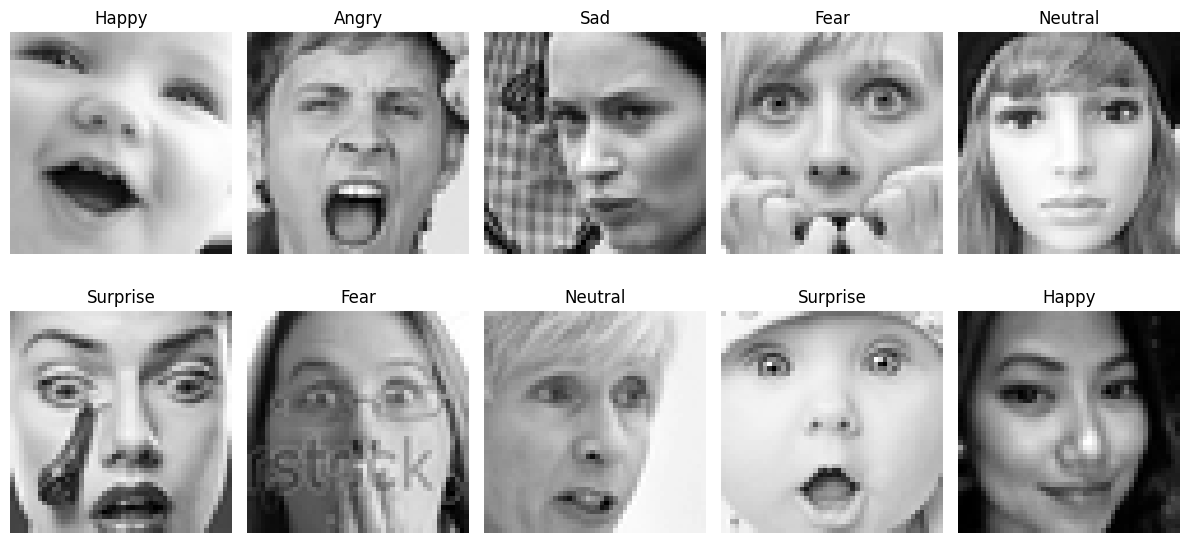

In [ ]:
# Define the class labels
class_labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

# Set the range of images to display
start_index = 10  # Start index of the range
end_index = 19    # End index of the range (inclusive)

# Create a figure with a 2x5 grid of subplots
fig, axes = plt.subplots(2, 5, figsize=(12, 6))

# Plot each image with its corresponding label within the specified range
for i in range(2):
    for j in range(5):
        index = start_index + i * 5 + j  # Calculate the index for accessing the images and labels
        if index <= end_index:
            image = images[index].squeeze()  # Remove the channel dimension if present
            label = class_labels[predicted[index]]  # Get the predicted label

            # Plot the image and label
            axes[i, j].imshow(image, cmap='gray')
            axes[i, j].set_title(label)
            axes[i, j].axis('off')

# Adjust the spacing between subplots
plt.tight_layout()

# Display the plot
plt.show()
